In [40]:
import torch
from torch import nn
import numpy as np
from loss import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from data import SICEDataset
from torch.utils.data import DataLoader
from loss import (
    TotalLoss,
    LocalColorLoss,
    GlobalColorLoss,
    LuminanceLoss,
    CurveSmoothnessLoss,
)
import os
from model import light_net


net = light_net()
net.eval()


BATCH_DIM = 0
CHANNEL_DIM = 1
HEIGHT_DIM = 2
WIDTH_DIM = 3


DATA_DIR = os.path.join("data", "sice_part1")
batch_size = 8
train_ds = SICEDataset(img_dir=DATA_DIR)
train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
)


X = torch.cat(
    (train_ds[1].unsqueeze(0), train_ds[2].unsqueeze(0), train_ds[51].unsqueeze(0))
)
X.shape

[2025-09-21 01:01:16,915] [INFO] Found 2002 images in data/sice_part1


torch.Size([2, 3, 512, 512])

In [ ]:
import matplotlib.pyplot as plt


def plot_tensor(x):
    # Convert to (H, W, C) for matplotlib
    img_np = x.permute(1, 2, 0).cpu().numpy()

    # Plot
    plt.imshow(img_np)
    plt.axis("off")  # optional, remove axes
    plt.show()


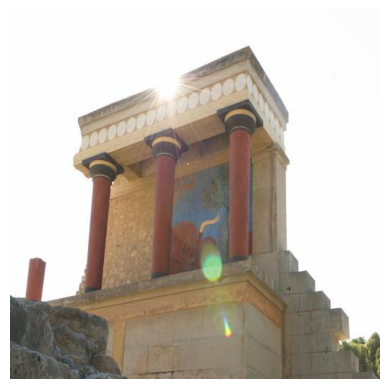

In [160]:
plot_tensor(X[0])

In [188]:
loss_fn = TotalLoss()


In [191]:
with torch.no_grad():
    # Extract estimated reflectance (color ratio) for original image
    per_pixel_intensity = torch.sum(X, dim=CHANNEL_DIM)
    E_original = X / (per_pixel_intensity.unsqueeze(CHANNEL_DIM) + 1e-4)

    # Model Inference
    I_enhanced, alphas, betas = net(X)

    # Extract estimated reflectance (color ratio) for enhanced image
    per_pixel_intensity = torch.sum(I_enhanced, dim=CHANNEL_DIM)
    E_enhanced = I_enhanced / (per_pixel_intensity.unsqueeze(CHANNEL_DIM) + 1e-4)

    # Loss
    loss = loss_fn(alphas, betas, I_enhanced, E_original, E_enhanced)

Local loss tensor(0.0045)
Global loss tensor(0.0016)
lum loss tensor(0.2983)
alpha loss tensor(0.0619)
beta loss tensor(0.0014)


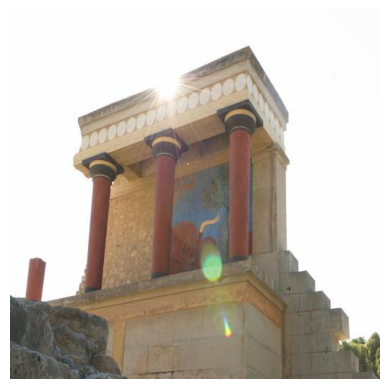

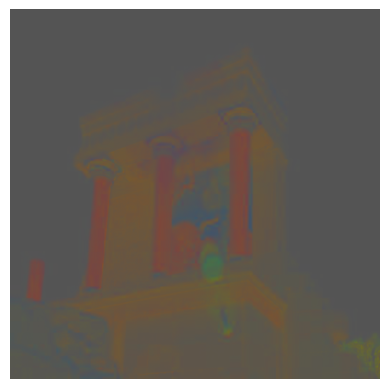

[2025-09-21 01:11:26,293] [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04016671..1.02406].


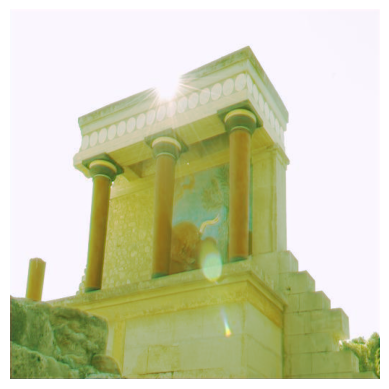

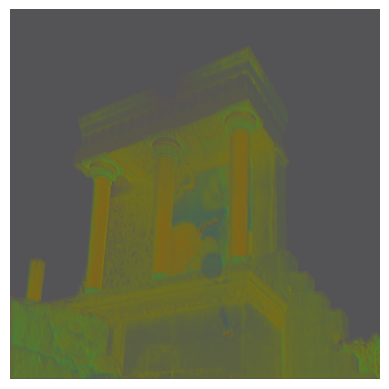

In [174]:
plot_tensor(X[0])
plot_tensor(E_original[0])
plot_tensor(I_enhanced[0])
plot_tensor(E_enhanced[0])

/tmp/ipykernel_53816/2448653256.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("trained_model.pth")


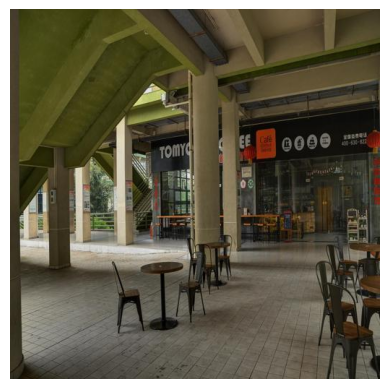

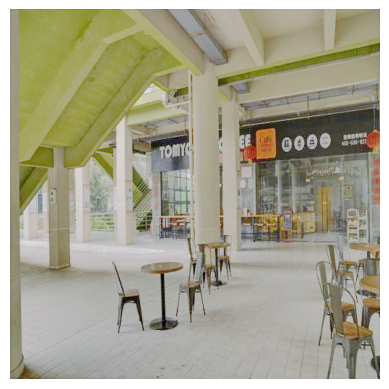

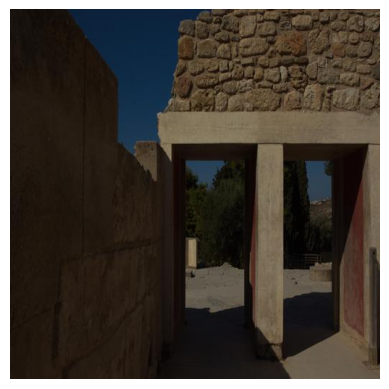

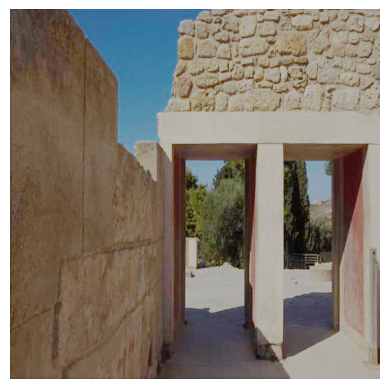

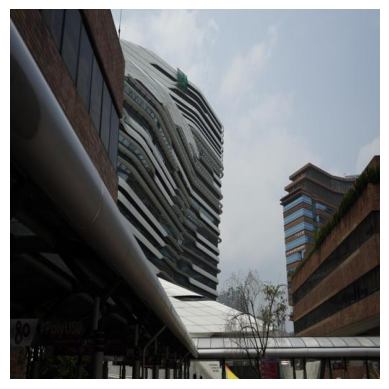

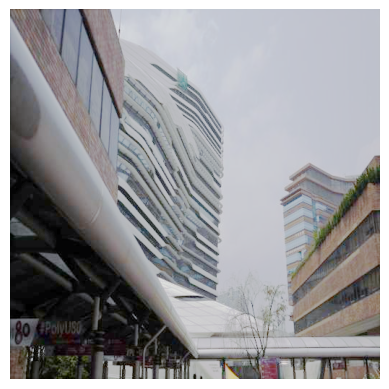

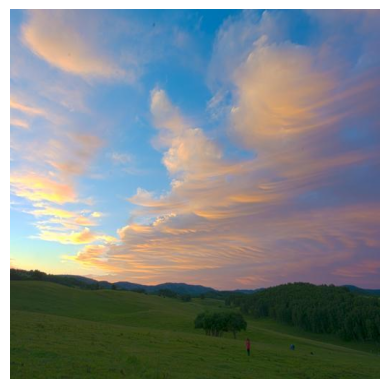

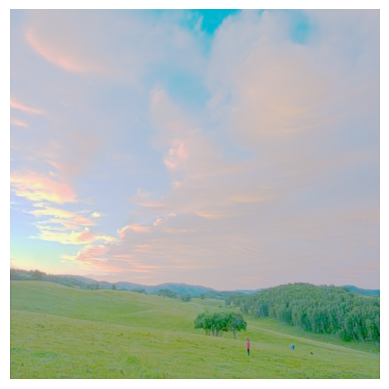

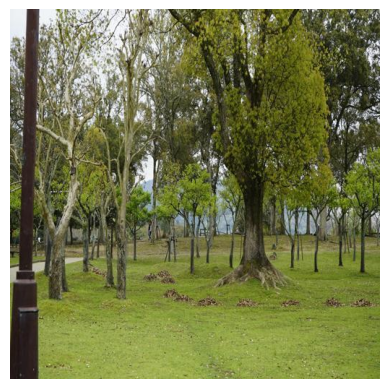

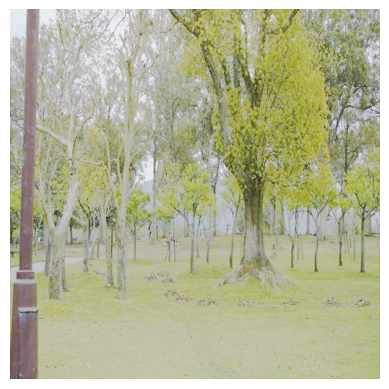

In [196]:
# After 5 epoch training:
net = light_net()
state_dict = torch.load("trained_model.pth")
net.load_state_dict(state_dict)
net.eval()
i = 0
with torch.no_grad():
    for X in train_dl:
        I_enhanced, alphas, betas = net(X)
        plot_tensor(X[0])
        plot_tensor(I_enhanced[0])
        i+=1
    
        if i == 5:
            break

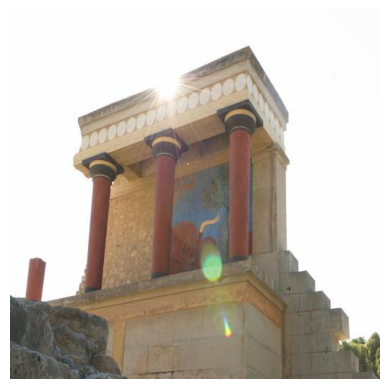

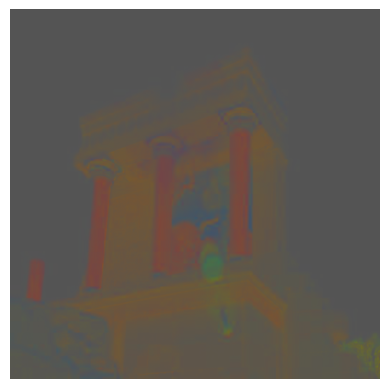

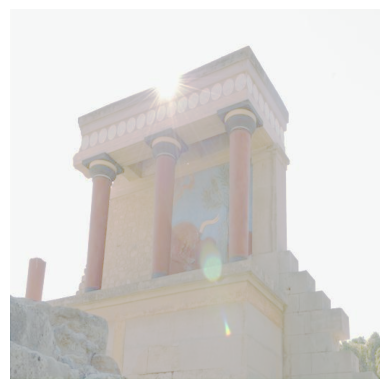

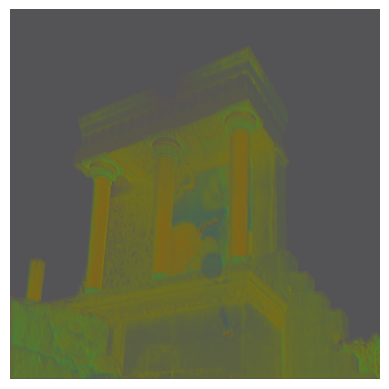

In [ ]:
plot_tensor(X[0])
plot_tensor(I_enhanced[0])
plot_tensor(E_original[0])
plot_tensor(E_enhanced[0])